# References

https://gym.openai.com/docs/

https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

https://mspries.github.io/jimmy_pendulum.html

https://stackoverflow.com/questions/42787924/why-is-episode-done-after-200-time-steps-gym-environment-mountaincar

https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html

https://keras.io/examples/rl/ddpg_pendulum/

https://medium.com/intro-to-artificial-intelligence/the-actor-critic-reinforcement-learning-algorithm-c8095a655c14

https://www.tensorflow.org/guide/keras/save_and_serialize



# Imports

In [106]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# A lit more about Pendulum ENV

In [107]:
# env = gym.envs.make("Pendulum-v0")
env = gym.make("Pendulum-v1").env
# It is just as the same as v0 but seems that has been deleted from accessible envs and I could not ru with v0 on my system. But it seems that reults are the same. For reproducing if you could not run with v1 change it to v0
# We use theta in degree instead of sin(theta) and cos(theta) so we change the num_state to 1

def env_info_extractor(env):

    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
        
    return num_states-1, num_actions, upper_bound, lower_bound


num_states, num_actions, upper_bound, lower_bound = env_info_extractor(env)

In [108]:
env_info_extractor(env)

(2, 1, 2.0, -2.0)

# Buffer

In [109]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


        
# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

# Actor-Critic Models

In [113]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(512, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(32, activation="relu")(state_input)
    state_out = layers.Dense(64, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(64, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(512, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


def policy(state, actor_model):
    sampled_actions = tf.squeeze(actor_model(state))
    sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

# Preprocess state
Theta can be accessed directly (in radians) from env but I have implemented it myself, since I didn't know it is possible and then I got it.

In [114]:
def to_degree(state):
    out = np.arctan2(state[1],state[0])
    return out


def state_transform(state):
    theta_dot = state[2]
    theta = to_degree(state)
    transformed_state = np.array([theta, theta_dot])
    
    return transformed_state

# Train and Test  Function

In [115]:
def run_env( MAX_EPISODES, MAX_STEPS, env, buffer, gamma, tau, actor_model, target_actor, target_critic, critic_model, train=True, render=False):
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []

    # Takes about 4 min to train
    for ep in range(MAX_EPISODES):

        prev_state = env.reset()
        episodic_reward = 0
        current_reward = []
        
        prev_state = state_transform(prev_state)
        

        for step_counter in range(MAX_STEPS):

            # Uncomment this to see the Actor in action
            # But not in a python notebook.
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = policy(tf_prev_state, actor_model)
            # Recieve state and reward from environment.
            state, reward, done, info = env.step(action)
            
            state = state_transform(state)
            
            episodic_reward += reward
            
            
            if train:
                buffer.record((prev_state, action, reward, state))
                buffer.learn()
                update_target(target_actor.variables, actor_model.variables, tau)
                update_target(target_critic.variables, critic_model.variables, tau)

            prev_state = state
            
            current_reward.append(reward)

        ep_reward_list.append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        print(f"Episode * {ep} * Avg Reward is ==> {avg_reward} * Current Episode Reward: {episodic_reward}")
        
        avg_reward_list.append(avg_reward)
        env.close()
        
    return [current_reward, ep_reward_list, avg_reward_list, actor_model, target_actor, target_critic, critic_model]

# Init and train model

In [116]:
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

In [117]:
MAX_EPISODES = 40
MAX_STEPS = 500

# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

In [118]:
# You can turn off render in train process for relatively faster training.
out = run_env(MAX_EPISODES, MAX_STEPS, env, buffer, gamma, tau, actor_model, target_actor, target_critic, critic_model, train=True, render=True)

current_reward_train, ep_reward_list_train, avg_reward_list_train, actor_model, target_actor, target_critic, critic_model = out

Episode * 0 * Avg Reward is ==> -3969.021269951552 * Current Episode Reward: -3969.021269951552
Episode * 1 * Avg Reward is ==> -3879.4734603541056 * Current Episode Reward: -3789.9256507566593
Episode * 2 * Avg Reward is ==> -3987.3385183686173 * Current Episode Reward: -4203.06863439764
Episode * 3 * Avg Reward is ==> -3930.542210276012 * Current Episode Reward: -3760.153285998196
Episode * 4 * Avg Reward is ==> -3764.926285870481 * Current Episode Reward: -3102.462588248358
Episode * 5 * Avg Reward is ==> -3702.8591880205627 * Current Episode Reward: -3392.523698770973
Episode * 6 * Avg Reward is ==> -3540.3712671470353 * Current Episode Reward: -2565.443741905871
Episode * 7 * Avg Reward is ==> -3564.843721333174 * Current Episode Reward: -3736.1509006361416
Episode * 8 * Avg Reward is ==> -3522.073821848352 * Current Episode Reward: -3179.914625969779
Episode * 9 * Avg Reward is ==> -3555.0303950900256 * Current Episode Reward: -3851.6395542650835
Episode * 10 * Avg Reward is ==> 

# Save and Load Models

In [119]:
# Save models and load them for future uses.
def save_models(models_path):
    actor_model.save(models_path[0], include_optimizer=True)
    critic_model.save(models_path[1], include_optimizer=True)

    target_actor.save(models_path[2], include_optimizer=True)
    target_critic.save(models_path[3], include_optimizer=True)

    
def load_models(models_path):

    actor_model = tf.keras.models.load_model(models_path[0])
    actor_model.compile(optimizer=actor_optimizer, loss="mse", metrics=[])

    critic_model = tf.keras.models.load_model(models_path[1])
    critic_model.compile(optimizer=critic_optimizer, loss="mse", metrics=[])


    target_actor = tf.keras.models.load_model(models_path[2])
    target_actor.compile(optimizer=actor_optimizer, loss="mse", metrics=[])

    target_critic = tf.keras.models.load_model(models_path[3])
    target_critic.compile(optimizer=critic_optimizer, loss="mse", metrics=[])

    
    return actor_model, critic_model, target_actor, target_critic

In [129]:
models_path = ["pendulum_actor.h5", "pendulum_critic.h5", "pendulum_target_actor.h5", "pendulum_target_critic.h5"]

# save_models(models_path)

# actor_model, critic_model, target_actor, target_critic = load_models(models_path)

# Test model

In [121]:
MAX_EPISODES_TEST = 10
MAX_STEPS_TEST = 200

out = run_env(MAX_EPISODES_TEST, MAX_STEPS_TEST, env, buffer, gamma, tau, actor_model, target_actor, target_critic, critic_model, train=False, render=True)
current_reward_test, ep_reward_list_test, avg_reward_list_test, actor_model, target_actor, target_critic, critic_model = out

Episode * 0 * Avg Reward is ==> -119.62727607353766 * Current Episode Reward: -119.62727607353766
Episode * 1 * Avg Reward is ==> -124.15630219207836 * Current Episode Reward: -128.68532831061904
Episode * 2 * Avg Reward is ==> -121.11954259277304 * Current Episode Reward: -115.04602339416246
Episode * 3 * Avg Reward is ==> -212.2279052061021 * Current Episode Reward: -485.5529930460893
Episode * 4 * Avg Reward is ==> -193.50157161182318 * Current Episode Reward: -118.59623723470749
Episode * 5 * Avg Reward is ==> -222.8858136951029 * Current Episode Reward: -369.80702411150156
Episode * 6 * Avg Reward is ==> -224.92667698453616 * Current Episode Reward: -237.1718567211356
Episode * 7 * Avg Reward is ==> -240.32858255088925 * Current Episode Reward: -348.141921515361
Episode * 8 * Avg Reward is ==> -238.63950248520814 * Current Episode Reward: -225.12686195975917
Episode * 9 * Avg Reward is ==> -250.45418941430688 * Current Episode Reward: -356.7863717761959


# Plot rewards

In [122]:
# plot rewatds
def plot_rewards(rewards, limit=False, bottom=-3, top=8, ylabel="Rewards of step"):
    plt.figure(figsize=(15, 8))
    xticks = len(rewards)
            
    plt.plot(range(1,xticks+1), rewards)
    if limit:
        plt.ylim(top=top)
        plt.ylim(bottom=bottom)
            
    plt.xlabel("Steps")
    plt.ylabel(ylabel)

    plt.show()

# Train Rewards Plot

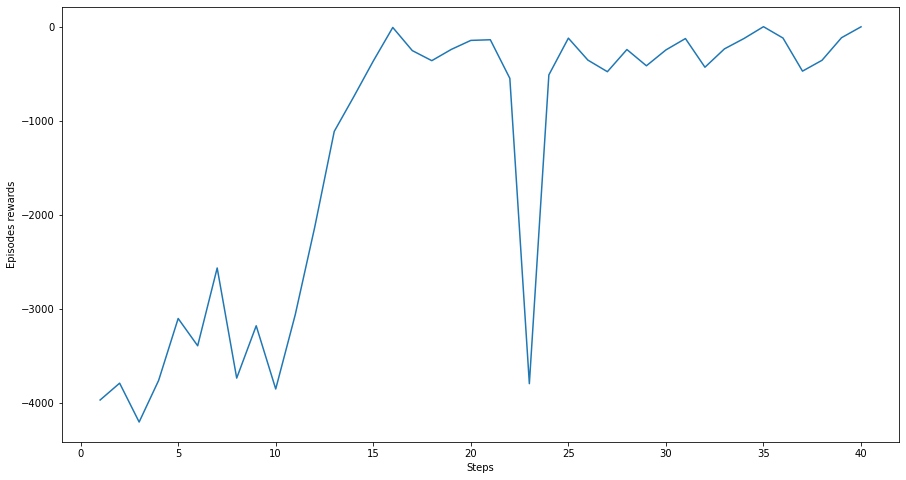

In [123]:
plot_rewards(ep_reward_list_train, ylabel="Episodes rewards")

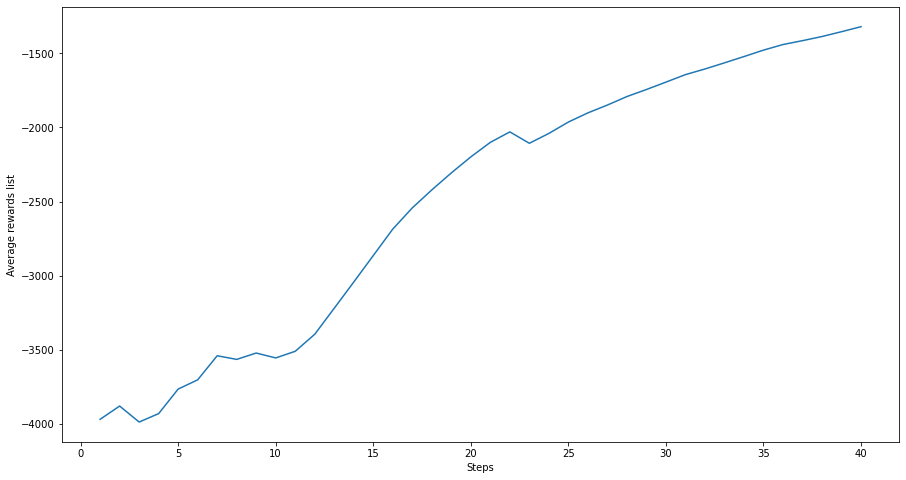

In [124]:
plot_rewards(avg_reward_list_train, ylabel="Average rewards list")

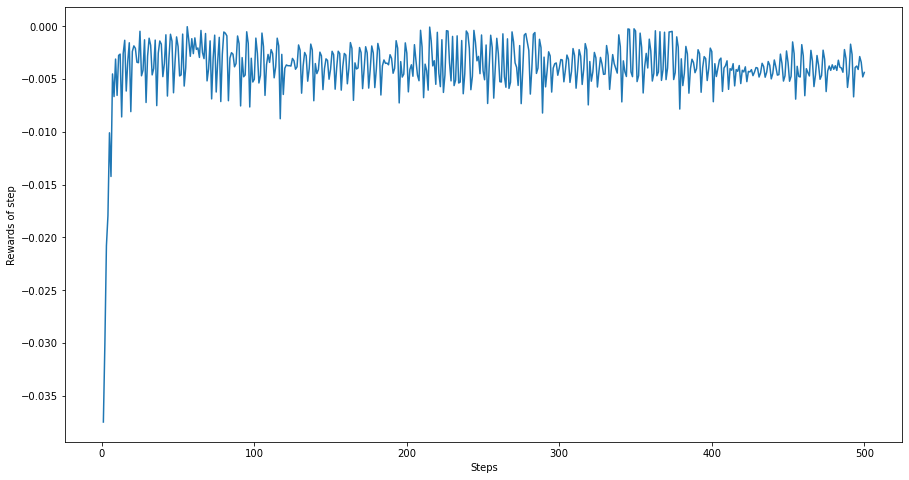

In [125]:
plot_rewards(current_reward_train)

# Test Rewards Plot

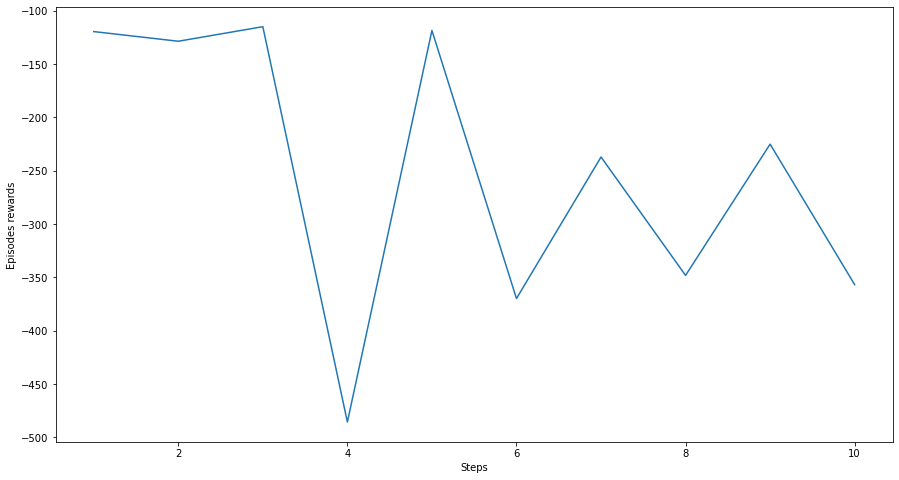

In [126]:
plot_rewards(ep_reward_list_test, ylabel="Episodes rewards")

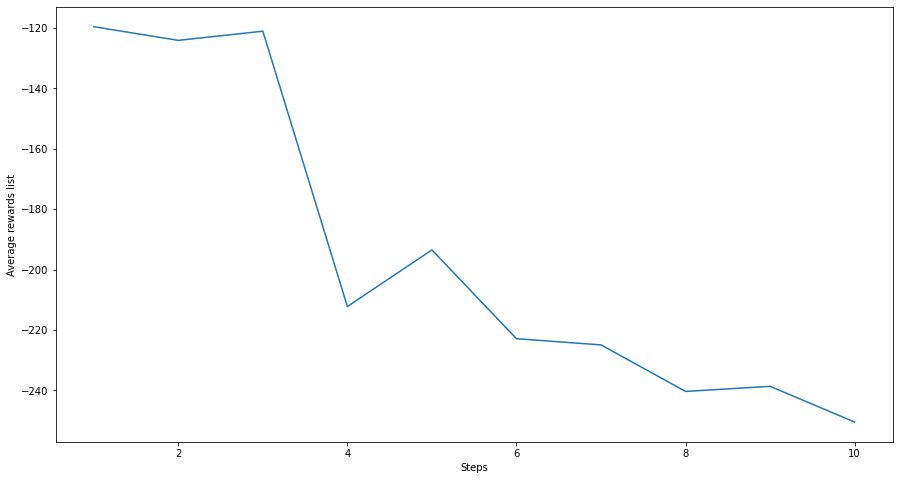

In [127]:
plot_rewards(avg_reward_list_test, ylabel="Average rewards list")

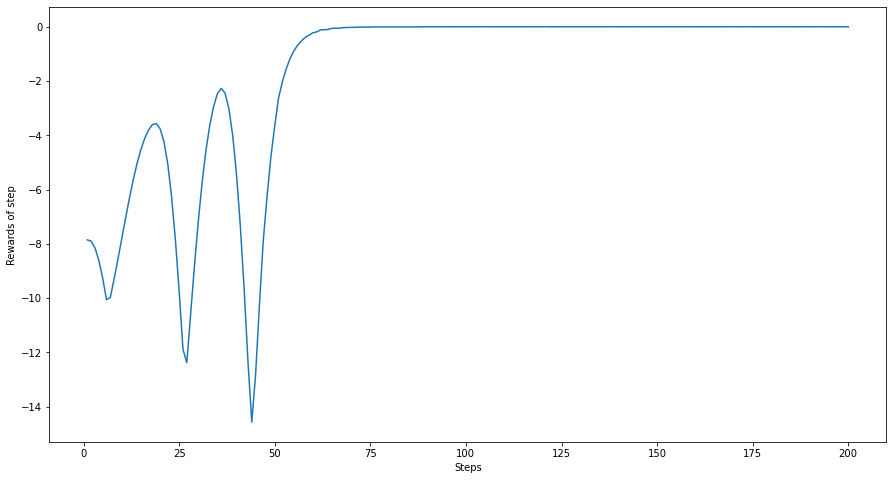

In [128]:
plot_rewards(current_reward_test)